In [3]:
# from IPython.external import mathjax; mathjax.install_mathjax()

In [1]:
r"""
Filename: lucastree.py

Authors: Thomas Sargent, John Stachurski, Spencer Lyon

Solves the price function for the Lucas tree in a continuous state
setting, using piecewise linear appoximation for the sequence of
candidate price functions.  The consumption endownment follows the log
linear AR(1) process

.. math::

    log y' = \alpha log y + \sigma \epsilon

where y' is a next period y and epsilon is an iid standard normal shock.
Hence

.. math::

    y' = y^{\alpha} * \xi,

where

.. math::

    \xi = e^(\sigma * \epsilon)

The distribution phi of xi is

.. math::

    \phi = LN(0, \sigma^2),

where LN means lognormal.

"""
from __future__ import division  # == Omit for Python 3.x == #
import numpy as np
from scipy import interp
from scipy.stats import lognorm
from scipy.integrate import fixed_quad
from quantecon.compute_fp import compute_fixed_point


class LucasTree(object):
    """
    Class to solve for the price of a the Lucas tree in the Lucas
    asset pricing model

    Parameters
    ----------
    gamma : scalar(float)
        The coefficient of risk aversion in the household's CRRA utility
        function
    beta : scalar(float)
        The household's discount factor
    alpha : scalar(float)
        The correlation coefficient in the shock process
    sigma : scalar(float)
        The volatility of the shock process
    grid : array_like(float), optional(default=None)
        The grid points on which to evaluate the asset prices. Grid
        points should be nonnegative. If None is passed, we will create
        a reasonable one for you

    Attributes
    ----------
    gamma, beta, alpha, sigma, grid : see Parameters
    grid_min, grid_max, grid_size : scalar(int)
        Properties for grid upon which prices are evaluated
    phi : scipy.stats.lognorm
        The distribution for the shock process

    Examples
    --------
    >>> tree = LucasTree(gamma=2, beta=0.95, alpha=0.90, sigma=0.1)
    >>> grid, price_vals = tree.grid, tree.compute_lt_price()

    """

    def __init__(self, gamma, beta, alpha, sigma, grid=None):
        self.gamma = gamma
        self.beta = beta
        self.alpha = alpha
        self.sigma = sigma

        # == set up grid == #
        if grid is None:
            (self.grid, self.grid_min,
             self.grid_max, self.grid_size) = self._new_grid()
        else:
            self.grid = np.asarray(grid)
            self.grid_min = min(grid)
            self.grid_max = max(grid)
            self.grid_size = len(grid)

        # == set up distribution for shocks == #
        self.phi = lognorm(sigma)

        # == set up integration bounds. 4 Standard deviations. Make them
        # private attributes b/c users don't need to see them, but we
        # only want to compute them once. == #
        self._int_min = np.exp(-4.0 * sigma)
        self._int_max = np.exp(4.0 * sigma)

        # == Set up h from the Lucas Operator == #
        self.h = self._init_h()

    def _init_h(self):
        """
        Compute the function h in the Lucas operator as a vector of
        values on the grid

        Recall that h(y) = beta * int u'(G(y,z)) G(y,z) phi(dz)
        """
        alpha, gamma, beta = self.alpha, self.gamma, self.beta
        grid, grid_size = self.grid, self.grid_size

        h = np.empty(grid_size)

        for i, y in enumerate(grid):
            # == u'(G(y,z)) G(y,z) == #
            integrand = lambda z: (y**alpha * z)**(1 - gamma)
            h[i] = beta * self.integrate(integrand)

        return h

    def _new_grid(self):
        """
        Construct the default grid for the problem

        This is defined to be np.linspace(0, 10, 100) when alpha > 1
        and 100 evenly spaced points covering 4 standard deviations
        when alpha < 1
        """
        grid_size = 100
        if abs(self.alpha) >= 1.0:
            grid_min, grid_max = 0.0, 10.0
        else:
            # == Set the grid interval to contain most of the mass of the
            # stationary distribution of the consumption endowment == #
            ssd = self.sigma / np.sqrt(1 - self.alpha**2)
            grid_min, grid_max = np.exp(-4 * ssd), np.exp(4 * ssd)

        grid = np.linspace(grid_min, grid_max, grid_size)

        return grid, grid_min, grid_max, grid_size

    def integrate(self, g, int_min=None, int_max=None):
        """
        Integrate the function g(z) * self.phi(z) from int_min to
        int_max.

        Parameters
        ----------
        g : function
            The function which to integrate

        int_min, int_max : scalar(float), optional
            The bounds of integration. If either of these parameters are
            `None` (the default), they will be set to 4 standard
            deviations above and below the mean.

        Returns
        -------
        result : scalar(float)
            The result of the integration

        """
        # == Simplify notation == #
        phi = self.phi
        if int_min is None:
            int_min = self._int_min
        if int_max is None:
            int_max = self._int_max

        # == set up integrand and integrate == #
        integrand = lambda z: g(z) * phi.pdf(z)
        result, error = fixed_quad(integrand, int_min, int_max)
        return result

    def lucas_operator(self, f, Tf=None):
        """
        The approximate Lucas operator, which computes and returns the
        updated function Tf on the grid points.

        Parameters
        ----------
        f : array_like(float)
            A candidate function on R_+ represented as points on a grid
            and should be flat NumPy array with len(f) = len(grid)

        Tf : array_like(float)
            Optional storage array for Tf

        Returns
        -------
        Tf : array_like(float)
            The updated function Tf

        Notes
        -----
        The argument `Tf` is optional, but recommended. If it is passed
        into this function, then we do not have to allocate any memory
        for the array here. As this function is often called many times
        in an iterative algorithm, this can save significant computation
        time.

        """
        grid,  h = self.grid, self.h
        alpha, beta = self.alpha, self.beta

        # == set up storage if needed == #
        if Tf is None:
            Tf = np.empty_like(f)

        # == Apply the T operator to f == #
        Af = lambda x: interp(x, grid, f)  # Piecewise linear interpolation

        for i, y in enumerate(grid):
            Tf[i] = h[i] + beta * self.integrate(lambda z: Af(y**alpha * z))

        return Tf

    def compute_lt_price(self, error_tol=1e-3, max_iter=50, verbose=0):
        """
        Compute the equilibrium price function associated with Lucas
        tree lt

        Parameters
        ----------
        error_tol, max_iter, verbose
            Arguments to be passed directly to
            `quantecon.compute_fixed_point`. See that docstring for more
            information

        Returns
        -------
        price : array_like(float)
            The prices at the grid points in the attribute `grid` of the
            object

        """
        # == simplify notation == #
        grid, grid_size = self.grid, self.grid_size
        lucas_operator, gamma = self.lucas_operator, self.gamma

        # == Create storage array for compute_fixed_point. Reduces  memory
        # allocation and speeds code up == #
        Tf = np.empty(grid_size)

        # == Initial guess, just a vector of zeros == #
        f_init = np.zeros(grid_size)
        f = compute_fixed_point(lucas_operator, f_init, error_tol,
                                max_iter, verbose, Tf=Tf)

        price = f * grid**gamma

        return price

In [2]:
tree = LucasTree(gamma=2, beta=0.95, alpha=0.00, sigma=0.1)
grid, price_vals = tree.grid, tree.compute_lt_price()

In [3]:
grid, price_vals = tree.grid, tree.compute_lt_price()

In [3]:
import pylab as plt

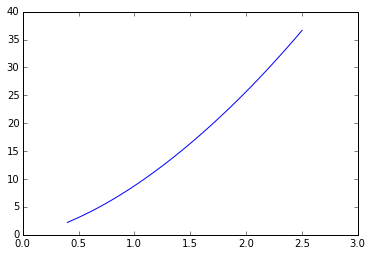

In [4]:
plt.plot(grid, price_vals)